## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from statistics import mode

# For plotting the decision Tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')


In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/nimisha/ana

## Getting the Score information for each Team from `output.csv`

In [2]:
def getScores(data):
    
    # Convert all the entities to lower case
    data['name'] = data['name'].apply(lambda x: x.lower())

    # remove all punctuations and spaces, now concatenate the string
    data['name'] = data['name'].str.replace(r'\W+', '').astype('str')

    #unnecessary column
    data.drop(columns=['score2'],inplace = True)

    #based on the value of the columns divide into different classes.
    #output['isEff'] = np.where(output.score1 > 40, 'Yes' , 'No')
    data['isEff'] = np.where(data.score1 > 40, np.where(data.score1 > 70, 'Yes' , 'Mod'), 'No')

    data.team_id = data.team_id.astype(str)

    # Create dictionaries
    # Inorder to map the scores with the team Name
    # The output.csv file contains the teamName and score Data
    # Hence we need to map the scores for the different members of the team in the other data

    nameMap = dict(zip(data.name,output.isEff))
    idMap = dict(zip(data.team_id,output.isEff))
    idToNameMap = dict(zip(data.team_id,output.name))
    opParams = {
                'nameMap': nameMap,
                'idMap': idMap,
                'idToNameMap': idToNameMap
    }
    return opParams
    
# This file is contains the score of differnt teams
# `output.csv` does not contain team information It only contains the Team and its score information
output = pd.read_csv('output.csv')
opParams = getScores(output)


# Functions for Data Preprocessing

In [3]:
# Create a new column isEff
# using the dictionary maps created earlier 
def isEff(data,opParams):
    nameMap = opParams['nameMap']
    idMap = opParams['idMap']
    idToNameMap = opParams['idToNameMap']
    data['isEff'] = data['teamName'].map(nameMap)
    data['teamName'] = np.where(data['teamName'].str.contains(pat = '^[0-9].*'),data['teamName'].map(idToNameMap), data['teamName'] )
    data['isEff'] = np.where(pd.isnull(data.isEff) ,data['teamName'].map(nameMap),data.isEff)
    data['isEff'] = np.where(pd.isnull(data.isEff) ,data['teamName'].map(idMap),data.isEff)
    #print(data[['teamName','isEff']])
    return data


# Preprocessing for the teamName attribute to conver to lowercase and remove all spaces and punctuation 
def teamNameProcessing(data):
    data['teamName'] = data['teamName'].astype('str').apply(lambda x: x.lower())
    data['teamName'] = data['teamName'].str.replace(r'\W+','').astype('str')
    
# After team Name Processing we want to convert the data into percentages
def percentage(x,val1,val2):
    c1 = 0
    c2 = 0
    for a in x:    
        if a == val1:
            c1=c1+1
        elif a == val2:
            c2=c2+1
            
    ratio = round(c1/(c1+c2),2)*100
    return ratio

#We need to convert the data to an apporpriate format
def convertToTeamData(data,newAttr,oldAttr,val1,val2):
    data[newAttr] = data[oldAttr].str.split(',').apply(lambda x:sorted(x))
    data[newAttr] =  data[newAttr].apply(percentage, args = (val1,val2))
    return data


# Converting percentage into yes or no Attributes based on a threshold
def convertToCategorical(data,attr,val,cat):
    data[attr] = np.where(data[attr] < val, cat[0], cat[1])

In [4]:
def preprocessing(data,opParams):
    teamNameProcessing(data)

    # Create a new Attribute Impact to see if a person is motivated to continue woring with the team
    data['Influence'] = np.where(data.workedEarlier == 'No' , np.where(data.workAgain == 'Yes', 'Positive' , 'Negative'), np.where(data.workAgain == 'Yes', 'Neutral' , 'Negative'))
    
    # Get all the Numerical data together
    numerical = data.groupby('teamName').mean().reset_index()
    
    '''
    Creating a Attribute: 
    'equality': This attribute is a combination of equalContribution and cooperation 
    'equalContribution' indicates that all the memebers of the team contributed for the project, which implies
    that the co-operation among the members in the group was good.
    
    'socialOrder':  This attribute is a combination of equalContribution and cooperation 
    '''
    numerical['equality'] =numerical[['equalContribution','cooperation']].mean(axis = 1)
    numerical['socialOrder'] =numerical[['equalContribution','appreciation','cooperation','freedom']].mean(axis = 1)
    
    #convertToCategorical(numerical,'Difficulty',4)
    convertToCategorical(numerical,'equalContribution',4,['No','Yes'])
    convertToCategorical(numerical,'appreciation',4,['No','Yes'])
    convertToCategorical(numerical,'cooperation',4,['No','Yes'])
    convertToCategorical(numerical,'freedom',4,['No','Yes'])
    convertToCategorical(numerical,'socialOrder',4,['No','Yes'])
    convertToCategorical(numerical,'equality',4,['No','Yes'])


    # Get all the Categorical data together
    # each row represents a team
    # the combination of the various responses of the members of the team for each categorical column
    # is of the format: 
    #[opinin1, opinion2, opinion3, opinion4] for a 4 membered team
    #[opinin1, opinion2, opinion3] for a 3 membered team
    categorical = data.groupby('teamName').agg(','.join).reset_index()


    # setting the opinion to the mode of the attribute
    categorical['Influence'] = categorical['Influence'].str.split(',')
    categorical['Influence'] = categorical['Influence'].apply(lambda x: max(set(x), key = x.count))

    # To obtain the size of the team
    categorical['size'] = categorical['Gender'].str.split(',').str.len()
    categorical = isEff(categorical,opParams)


    # Convert all the attributes to percentages
    categorical = convertToTeamData(categorical,'femalePercent','Gender','Female','Male')    
    categorical = convertToTeamData(categorical,'IntrovertPercent','EI','Introvert','Extrovert')  
    categorical = convertToTeamData(categorical,'IntuitionPercent','SI','Intuition','Sensation')
    categorical = convertToTeamData(categorical,'ThinkingPercent','TF','Thinking','Feeling')
    categorical = convertToTeamData(categorical,'JudgementPercent','JP','Judgement','Perception')  
    categorical = convertToTeamData(categorical,'workedEarlierPercent','workedEarlier','Yes','No')  
    categorical = convertToTeamData(categorical,'workAgainPercent','workAgain','Yes','No') 

    # Drop unnecessary attributes
    categorical.drop(['Gender', 'Personality', 'EI', 'SI', 'TF', 'JP',
           'workedEarlier','workAgain','Temperament'],axis = 1,inplace = True)

    
    convertToCategorical(categorical,'femalePercent',50,['FPLow','FPHigh'])
    convertToCategorical(categorical,'IntrovertPercent',50,['IELow','IEHigh'])
    convertToCategorical(categorical,'IntuitionPercent',50,['INLow','INHigh'])
    convertToCategorical(categorical,'ThinkingPercent',50,['TFLow','TFHigh'])
    convertToCategorical(categorical,'JudgementPercent',50,['JPLow','JPHigh'])
    convertToCategorical(categorical,'workedEarlierPercent',50,['WELow','WEHigh'])
    convertToCategorical(categorical,'workAgainPercent',50,['WALow','WAHigh'])

    teams = pd.merge(numerical,categorical, on = 'teamName')
    #teams.drop(['Difficulty','teamName','workedEarlierPercent','workAgainPercent','Improvement','equalContribution','appreciation','cooperation','freedom'],axis = 1,inplace = True)
    teams.drop(['Difficulty','teamName','workedEarlierPercent','workAgainPercent','Improvement'],axis = 1,inplace = True)
    teams.sort_values(by = 'isEff')
    teams.to_csv('FinalData.csv',index = False)

    return teams


# Read Data 
# Data wrt to each member of the team
# need to be later grouped wrt teamName

data = pd.read_csv('Data.csv')
teams = preprocessing(data,opParams)


# Models for Building a classifier

In [5]:
np.random.seed(0)
def prepare_data(teams):

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    
    # Label Encoding for the entire Data 
    # Both the dependent and the predictors variable
    # Separating the predictors and the dependent variable
    y = teams.isEff
    X = teams.drop('isEff',axis=1)

    le = preprocessing.LabelEncoder()
    X = X.apply(le.fit_transform)

    y = le.fit_transform(y)
    
    # Defined Manually after applying le.inverse_transform([0,1,2])
    class_names = {1:'Not Effective',2:'Effective',0:'Moderate'}

    # Store the names of the selected columns
    feature_names = X.columns
  
    
    
    # After the feature selection, split the data into train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20, random_state = 0)

    params = {
                'X': X,
                'y': y,
                'train_X': train_X,
                'test_X': test_X,
                'train_y': train_y,
                'test_y': test_y,
                'feature_names' : feature_names,
                'class_names' : class_names
                 
             }
    return params



In [6]:
np.random.seed(0)
def model_building(params,model,metric):
    
    X = params['X']
    y = params['y']
    train_X = params['train_X']
    train_y = params['train_y']
    test_X = params['test_X']
    test_y = params['test_y']
    class_names = params['class_names']
    
    # Apply K-Fold Cross Validation
    kfold = KFold(n_splits=4, random_state=3)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=metric)
    
    model.fit(train_X,train_y)
    pred = model.predict(test_X) 
    print(model)
    print('Cross-validation Score',cv_results.mean())
#    print(classification_report(test_y, pred))
#    cm = confusion_matrix(test_y, pred)
#    print('Confusion Matrix')
#    print(cm)
    # Compute the accuracy of the model
    acc = model.score(test_X, test_y)
    
    params['accuracy'] = round(cv_results.mean(),2)*100
    params['model'] = model
    
    return params

In [7]:
np.random.seed(0)
def findBestDepth(teams):

    params = prepare_data(teams)# No of features 
    

    train_X = params['train_X']
    train_y = params['train_y']
    test_X = params['test_X']
    test_y = params['test_y']
    #print(teams.apply(pd.Series.value_counts))
    max_depth = []
    acc_gini = []
    acc_entropy = []
    kfold = KFold(n_splits=4, random_state=0)
     
    for i in range(1,10):
        dtree = DecisionTreeClassifier(criterion='gini',random_state = 0,max_depth=i,min_samples_split = 10)
        cv_results = cross_val_score(dtree, train_X, train_y, cv=kfold, scoring='f1_micro')
        acc_gini.append(cv_results.mean())
        ####

        dtree = DecisionTreeClassifier(criterion= 'entropy',random_state = 0, max_depth=i,min_samples_split = 10)
        cv_results = cross_val_score(dtree, train_X, train_y, cv=kfold, scoring='f1_micro')
        acc_entropy.append(cv_results.mean())
        ####
        max_depth.append(i)
        d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
                          'acc_entropy':pd.Series(acc_entropy),
                          'max_depth':pd.Series(max_depth)})
    # visualizing changes in parameters
    plt.plot('max_depth','acc_gini',data = d, label = 'gini')
    plt.plot('max_depth','acc_entropy', data= d, label='entropy')

    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()

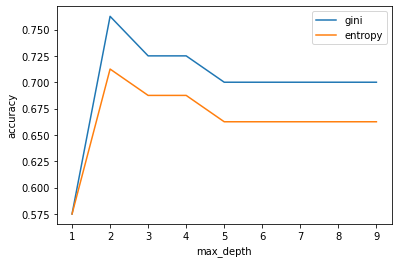

In [8]:
findBestDepth(teams)

In [9]:
np.random.seed(1)
def combiningModels(params,metric):
    
    accuracy = dict()
    
    dt = DecisionTreeClassifier(criterion='gini',random_state = 1,max_depth=3,min_samples_split = 10)
    params = model_building(params,dt,metric)
    accuracy['dt_accuracy'] = params['accuracy']
    
    
    log = LogisticRegression(
        multi_class = 'multinomial',
        penalty='l2',
        C=1.0,
        solver = 'saga')
    
    params = model_building(params,log,metric)
    accuracy['log_accuracy'] = params['accuracy']
    
    
    rf = RandomForestClassifier(n_estimators = 200,
                          max_depth = 5,                           
                           random_state=0)
    params = model_building(params,rf,metric)
    accuracy['RF_accuracy'] = params['accuracy']

   
    multiNB = MultinomialNB(alpha = 0.7,fit_prior=True)
    params = model_building(params,multiNB,metric)
    accuracy['NB_accuracy'] = params['accuracy']

    # https://scikit-l`earn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#examples-using-sklearn-ensemble-gradientboostingclassifier
    

    gbc = GradientBoostingClassifier(learning_rate = 0.1,
                                   max_depth = 3,
                                   min_samples_split=10,
                                     min_samples_leaf=3,
                                     random_state = 1)
    params = model_building(params,gbc,metric)
    accuracy['gbc_accuracy'] = params['accuracy']



    xgbc = XGBClassifier(
        n_estimators = 100,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=3,
        eta=0.8,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state = 1)
    params = model_building(params,xgbc,metric)
    accuracy['xgbc_accuracy'] = params['accuracy']

    
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
    
    etc = ExtraTreesClassifier(n_estimators=100, criterion='gini',
                               max_depth=5,
                               min_samples_split=10,
                               min_samples_leaf=2,
                               random_state = 1)
    params = model_building(params,etc,metric)
    accuracy['etc_accuracy'] = params['accuracy']
    '''
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 3)
    #fit model to training data
    params = model_building(params,knn)
    accuracy['knn_accuracy'] = params['accuracy']

    '''
    
    #create a dictionary of our models
    estimators=[('Decision_Tree', dt), ('Random_Forest', rf),('Extra_Trees_Classifier', etc),('Gradient_Boosting_Classifier', gbc),('Extreme_Gradient_Boosting_CLassifier', xgbc),('Multinomial_NB', multiNB),('Log_reg', log)]
    #create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='soft')
    params = model_building(params,ensemble,metric)
    accuracy['ensemble_accuracy'] = params['accuracy']
    
    return params,accuracy

params = prepare_data(teams)
params,accuracy = combiningModels(params,'accuracy')

finalModel = params['model']
pickle.dump(finalModel, open('finalModel.pkl','wb'))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Cross-validation Score 0.7100000000000001
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Cross-validation Score 0.74
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_l

In [10]:
accuracy

{'dt_accuracy': 71.0,
 'log_accuracy': 74.0,
 'RF_accuracy': 77.0,
 'NB_accuracy': 70.0,
 'gbc_accuracy': 74.0,
 'xgbc_accuracy': 77.0,
 'etc_accuracy': 73.0,
 'ensemble_accuracy': 76.0}

In [11]:
evaluation = pd.DataFrame.from_dict(accuracy, orient = 'index')
evaluation.columns = ['Accuracy']

Cross-validation Score [0.74074074 0.74074074 0.61538462] 0.6989553656220323


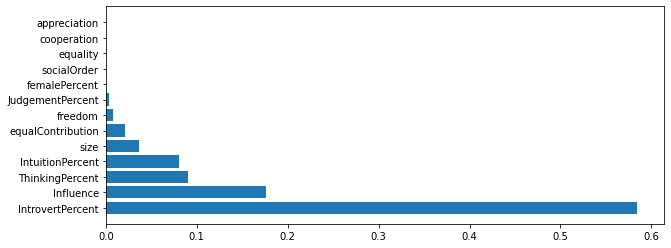

In [12]:
from sklearn.linear_model import LogisticRegression

rf = XGBClassifier(
        n_estimators = 100,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=3,
        eta=0.8,
        reg_alpha=0.5,
        reg_lambda=0.5,
        learning_rate = 0.001,
        random_state = 0)
    
train_X = params['train_X']
train_y = params['train_y']
test_X = params['test_X']
test_y = params['test_y']
kfold = KFold(n_splits=3, random_state=0)
cv_results = cross_val_score(rf, train_X, train_y, cv=kfold, scoring='f1_micro')

rf.fit(train_X,train_y)
pred = rf.predict(test_X) 
#print(rf.feature_importances_)
imp = rf.feature_importances_
# plot

print('Cross-validation Score',cv_results,cv_results.mean())



indices = np.argsort(imp)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [params['feature_names'][i] for i in indices]
plt.figure(figsize=(10,4))
plt.barh(params['feature_names'][indices], imp[indices])
plt.show()

In [13]:

metric = ['precision_weighted','recall_weighted','f1_weighted','roc_auc_ovr','roc_auc_ovo']

for kind in metric:
    print(kind)
    params,accuracy = combiningModels(params,kind)
    evaluation[kind] = accuracy.values()
    


precision_weighted
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Cross-validation Score 0.7647478354978355
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Cross-validation Score 0.7717821067821068
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='au

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=1, verbose=0,
                     warm_start=False)
Cross-validation Score 0.7300000000000001
VotingClassifier(estimators=[('Decision_Tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features=None,
                                   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Cross-validation Score 0.8575477063499509
MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)
Cross-validation Score 0.8396017161516388
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
               

VotingClassifier(estimators=[('Decision_Tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=

In [14]:
evaluation

,Accuracy,precision_weighted,recall_weighted,f1_weighted,roc_auc_ovr,roc_auc_ovo
dt_accuracy,71.0,76.0,71.0,69.0,79.0,76.0
log_accuracy,74.0,77.0,74.0,74.0,84.0,79.0
RF_accuracy,77.0,80.0,77.0,77.0,86.0,81.0
NB_accuracy,70.0,74.0,70.0,70.0,84.0,80.0
gbc_accuracy,74.0,77.0,74.0,75.0,85.0,82.0
xgbc_accuracy,77.0,78.0,77.0,77.0,85.0,82.0
etc_accuracy,73.0,80.0,73.0,73.0,86.0,81.0
ensemble_accuracy,76.0,78.0,76.0,75.0,85.0,82.0


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
Cross-validation Score 0.6905413105985863


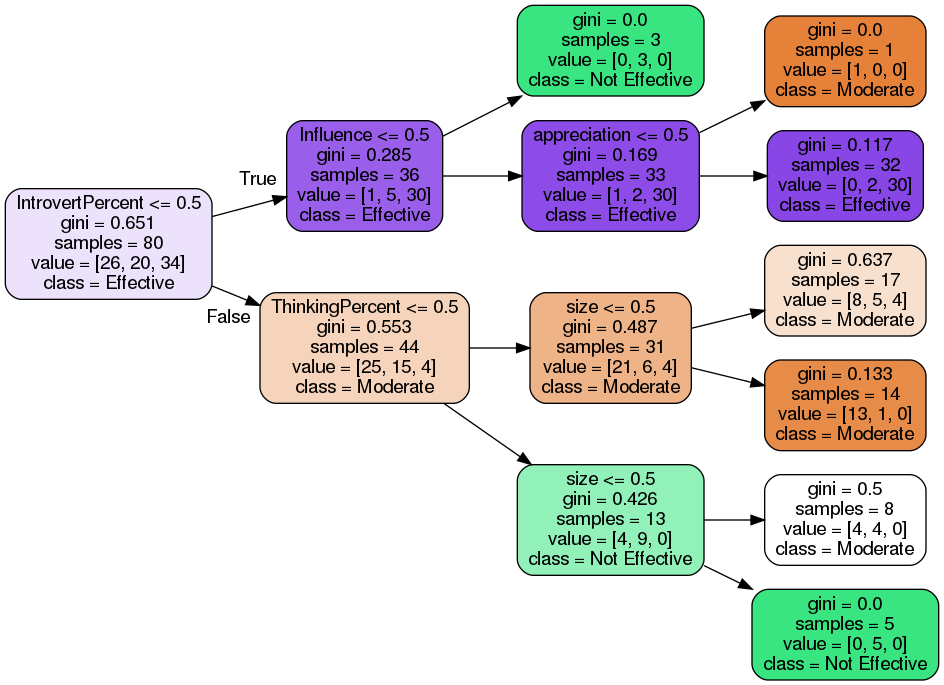

In [15]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini',random_state = 0,max_depth=3,min_samples_split = 10)

params = model_building(params,dt,'f1_weighted')
# create a string input output object
dot_data = StringIO()
export_graphviz(params['model'],
                out_file=dot_data,
                filled=True,
                rounded=True,
                
                rotate = True,
                feature_names=params['feature_names'],
                class_names=params['class_names'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())

# https://mlwave.com/kaggle-ensembling-guide/


'''
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='gini',max_depth=3)
bag = BaggingClassifier(tree, n_estimators=500, 
                        random_state=1,

                       )
params = model_building(params,bag)
accuracy['bag_accuracy'] = params['accuracy']

'''

  
    '''
    from sklearn.feature_selection import SelectKBest,chi2,f_classif,mutual_info_classif
    # Feature selection
    sel_chi2 = SelectKBest(score_func = mutual_info_classif, k=i)    
    sel_chi2.fit_transform(X, y)
    col_num = sel_chi2.get_support(indices = True)

    # Retaining only the selected K columns
    X = X.iloc[:,col_num]

    '''
    
    '''
    def splitToThree(data,attr,val1,val2,cat):
        data[attr] = np.where(data[attr] <= val1, cat[0],  np.where(data[attr] < val2, cat[1], cat[2]))
        
    # Convert the percentage to categories
    splitToThree(categorical,'femalePercent',33,50,['FPLow','FPLow','FPHigh'])
    splitToThree(categorical,'IntrovertPercent',33,50,['IELow','IELow','IEHigh'])
    splitToThree(categorical,'IntuitionPercent',33,50,['INLow','INLow','INHigh'])
    splitToThree(categorical,'ThinkingPercent',33,50,['TFLow','TFLow','TFHigh'])
    splitToThree(categorical,'JudgementPercent',33,50,['JPLow','JPLow','JPHigh'])
    splitToThree(categorical,'workedEarlierPercent',33,50,['WELow','WELow','WEHigh'])
    splitToThree(categorical,'workAgainPercent',33,50,['WALow','WALow','WAHigh'])
    '''
    
    


np.random.seed(1)
def find_best_k_features(teams):
    acc = []
    k = []
    for i in range(2,10):
        params = prepare_data(teams,i)
        k.append(i)
        params = model_building(params,3)
        acc.append(params['accuracy'])
        
    plt.plot(k,acc, label = 'accuracy')
    

    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.legend()

#find_best_k_features(teams)